# Le-Net 1 based architecture

We start with 41X41 (I) after first convolution (9x9)we have 33X33 (L1). The next pooling layer reduces dimension with 3 to an output image of 11X11 with 4x4 pooling kernels (L2). Then we apply different types of convolution 4x4 kernels on the L2 layer resulting in 8x8 (L3) . Then followed by pooling 2X2 resulting in 4x4 output map (L4). So we have 16 connection for each element in layer L4 (which depend on the amount of different Covolutions in L3) 


\begin{equation}
f(x)=\frac{1}{1+e^{-x}} \\
F_{k}= f( \sum_{i} \mathbf{W^{k}_{i} \cdot y_{i}}-b_{k})
\end{equation}

\begin{equation}
E=\sum_{k} \frac{1}{2}|t_k-F_{k}|^{2} \\
\Delta W_{ij}= - \eta \frac{dE}{d W_{ij}}
\end{equation}

\begin{equation}
\Delta W_{ij}= \sum_{k} - \eta \frac{dE}{d F_{k}} \frac{dF_{k}}{dx_{k}} \frac{dx_{k}}{dW_{ij}}=\sum_{k} \eta (t_{k}-F_{k})\frac{e^{-x_{k}}}{(1+e^{-x_{k}})^{2}} \frac{dx_{k}}{dW_{ij}} \\
= \eta (t_{k}-F_{k})\frac{e^{-x_{k}}}{(1+e^{-x_{k}})^{2}} y_{ij}
\end{equation}

\begin{equation}
\Delta b_{k}= - \eta \frac{dE}{d F_{k}} \frac{dF_{k}}{dx_{k}} \frac{dx_{k}}{b_{k}}=\eta (t_{k}-F_{k})\frac{e^{-x_{k}}}{(1+e^{-x_{k}})^{2}} \cdot-1
\end{equation}

Since $\frac{e^{-x_{k}}}{(1+e^{-x_{k}})^{2}}$ is always positive we can neglect this term in our programme

\begin{equation}
x_{k}=\sum_{ij} W^{k}[i,j] \; y^{4rb}[i,j] - b_{k}
\end{equation}

\begin{equation}
y^{4rb}[i,j]= \sum_{u,v} W^{3rb}[u,v] \; y^{3rb} [2i+u,2j+v]
\end{equation}

\begin{equation}
y^{3rb} [2i+u,2j+v]= f\left (x^{3rb}[2i+u,2j+v] \right)
\end{equation}

\begin{equation}
x^{3rb}[2i+u,2j+v]=\sum_{nm} W^{2rb}[n,m] \; y^{2rb}[n+(2i+u),m+(2j+v)] -b^{3rb}
\end{equation}

\begin{equation}
\begin{split}
\Delta W^{2rb}[n,m] =\sum_{k} - \eta  \frac{dE}{dF_{k}} 
\frac{dF_{k}}{dx_{k}} 
\sum_{ij} \frac{dx_{k}}{dy^{4rb}[i,j]} 
 \sum_{uv}\frac{dy^{4rb}[i,j]}{d y^{3rb} [2i+u,2j+v]} 
\frac{d y^{3rb} [2i+u,2j+v]}{d x^{3rb}[2i+u,2j+v]}
\sum_{nm}\frac{d x^{3rb}[2i+u,2j+v]}{d W^{2rb}[n,m]}
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\Delta b^{3rb}[2i+u,2j+v] =\sum_{k} - \eta  \frac{dE}{dF_{k}} 
\frac{dF_{k}}{dx_{k}} 
\sum_{ij} \frac{dx_{k}}{dy^{4rb}[i,j]} 
 \sum_{uv}\frac{dy^{4rb}[i,j]}{d y^{3rb} [2i+u,2j+v]} 
\frac{d y^{3rb} [2i+u,2j+v]}{d x^{3rb}[2i+u,2j+v]}
\frac{d x^{3rb}[2i+u,2j+v]}{d b^{3rb}[2i+u,2j+v]}
\end{split}
\end{equation}

\begin{equation}
    \frac{dx_{k}}{dy^{4rb}[i,j]} = W^{4rbk}[i,j]\\
\end{equation}

\begin{equation}
    \frac{dy^{4rb}[i,j]}{d y^{3rb} [2i+u,2j+v]} = W^{3rb}[u,v] \\
 \end{equation}
 

\begin{equation}
\frac{d y^{3rb} [2i+u,2j+v]}{d x^{3rb}[2i+u,2j+v]}=\frac{e^{-x^{3rb}[2i+u,2j+v]}}{(1+e^{-x^{3rb}[2i+u,2j+v]})^2}
\end{equation}
This term is first not included since it is always positive. If the training will not converge it might be possible to include this term

 \begin{equation}
    \frac{d y^{3rb} [2i+u,2j+v]}{d W^{2rb}[n,m]}= y^{2rb} [n+(2i+u),m+(2j+v)] \\
\end{equation}

\begin{equation}
\frac{d x^{3rb}[2i+u,2j+v]}{d b^{3rb}}=-1
\end{equation}

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as lin
import scipy.signal as sig
from PIL import Image
import glob
import matplotlib.cm as cm
import itertools

In [307]:
########### Load Input ############################################################################################################################
# In this script I used the brightness to determine structures, instead of one RGB color:
# this is determined by: 0.2126*R + 0.7152*G + 0.0722*B
# Source: https://en.wikipedia.org/wiki/Relative_luminance

patchSize=42 # patchsize this must be 48 since our network can only handle this value

# Open forest
Amount_data= len(glob.glob('Forest/F*'))
dataPatchedF=[]
for k in range (0, Amount_data):
    name="Forest/F%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data= np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture
    dataPatchedF.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)]))

# Open city
Amount_data= len(glob.glob('City/C*'))
dataPatchedC=[]
for k in range (0, Amount_data):
    name="City/C%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data = np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture    
    dataPatchedC.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)]))

# Open water
dataPatchedW=[]
Amount_data= len(glob.glob('Grassland/G*'))
for k in range (0, Amount_data): 
    name="Grassland/G%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data = np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture
    dataPatchedW.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)])) 
    

In [308]:
########### Functions ############################################################################################################################

# Define Activitation functions, pooling and convolution functions (the rules)

def Sigmoid(x): 
    return (1/(1+np.exp(-x)))

def SigmoidPrime(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

def TanH(x):
    return (1-np.exp(-x))/(1+np.exp(-x))


def Pool(I,W):
    PoolImg=np.zeros((len(I)/len(W),len(I)/len(W))) # W must fit an integer times into I.
    for i in range(0,len(PoolImg)):
        for j in range(0,len(PoolImg)):
            SelAr=I[i*len(W):(i+1)*len(W),j*len(W):(j+1)*len(W)]
            PoolImg[i,j]=np.inner(SelAr.flatten(),W.flatten()) # Now this is just an inner product since we have vectors
    return PoolImg

# To automatically make Gaussian kernels
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

# To automatically define pooling nodes
def Pool_node(N):
    s=(N,N)
    a=float(N)*float(N)
    return (1.0/a)*np.ones(s) 



In [506]:
#################### Define pooling layers ###########################################################################
P12=Pool_node(3)*(1.0/100.0) #factor 1000 added to lower values more
P34=Pool_node(2)

#################### Define Convolution layers #######################################################################

######### First C layer #########
C1=[]
Kernelsize=10
## First Kernel

# Inspiration: http://en.wikipedia.org/wiki/Sobel_operator
# http://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size

## First kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
for i in range(0,Kernelsize):
    for j in range(0,Kernelsize):
        if(i==j):Kernel[i,j]=1
        if(i>j): Kernel[i,j]=4
Kernel=(1/np.sum(Kernel))*Kernel         
C1.append(Kernel)

# ## Second Kernel
# # Kernel=np.matrix.transpose(Kernel)
# Kernel= [[np.sin(x) for x in np.linspace(0,15*np.pi,9)] for i in range(0,9)]
# C1.append(Kernel)

## Third Kernel
Kernel=makeGaussian(9,5)
Kernel=(1/np.sum(Kernel))*Kernel
C1.append(Kernel)

# ## Fourth Kernel
# Kernel=np.zeros((Kernelsize,Kernelsize))
# Kernel[0:4,:]=4
# Kernel[4:6,:]=1
# Kernel[6:10,:]=-4
# Kernel=(1/np.sum(Kernel))*Kernel         
# C1.append(Kernel)
        
## Fifth kernel
Kernel=(np.fliplr(C1[0])-C1[0])+2*(np.fliplr(C1[0])+C1[0])    
Kernel=(1/np.sum(Kernel))*Kernel   
C1.append(Kernel)

# #Sixth Kernel
# Kernel=makeGaussian(9,2)
# Kernel=(1/np.sum(Kernel))*Kernel
# C1.append(Kernel)

# ## Seventh Kernel
# Kernel= np.transpose([[np.sin(x) for x in np.linspace(0,5*np.pi,9)] for i in range(0,9)])+[[np.sin(x) for x in np.linspace(0,5*np.pi,9)] for i in range(0,9)]
# Kernel=(1/np.sum(Kernel))*Kernel    
# C1.append(Kernel)


# ## Eigth Kernel
# Kernel= np.transpose([[np.sin(x) for x in np.linspace(0,1*np.pi,9)] for i in range(0,9)])
# Kernel=(1/np.sum(Kernel))*Kernel    
# C1.append(Kernel)

# ## Ninth Kernel
# Kernel= np.transpose(C1[0])
# C1.append(Kernel)

## First kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
Kernel[3:7,3:7]=1
Kernel=(1/np.sum(Kernel))*Kernel         
C1.append(Kernel)


######### Initialize output weights and biases #########

# Initialisation, since this layer should be trained!
C2=[] # second convolutio weigths
H3_bias=[]
W=[] # end-weight from output to classifier-neurons
# Define the number of branches in one row
N_branches=3
ClassAmount=3 # Forest, City, Water


C2_b2=np.array([[-2,-2,-2,-2],
                [-1,-1,-1,-1],
                [0,0,0,0],
                [1,1,1,1]])
C2_b2=(1/np.sum(C2_b2))*C2_b2
C2_b3=np.array([[-1,-3,-3,-3],
                [-1,-1,-3,-3],
                [2,2,-1,-3],
                [2,2,2,-1]])
C2_b3=(1/np.sum(C2_b3))*C2_b3

for i in range (0, len(C1)):
    C2_kernel=np.random.rand(N_branches,4,4)*(1.0/100.0) 
    C2_kernel[1]=C2_kernel[0]*C2_b2
    C2_kernel[2]=C2_kernel[0]*C2_b3
    C2.append(C2_kernel)
    H3_bias.append(np.zeros((N_branches,1,1))*(1.0/10.0)) 
    W.append(np.random.rand(N_branches,ClassAmount,4,4)*(1.0/100.0)) # W[r][b,k,:,:]

bias=np.zeros((ClassAmount))# bias on the three classes

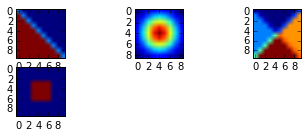

In [507]:
N_plts=len(C1)
for i in range(0,N_plts):
    plt.subplot(4,3,i+1)
    plt.imshow(C1[i])    

In [513]:
#################### Start training  #######################################################################

# Determines which patch is chosen when
N_F=len(dataPatchedF)
Patches_F=[]
j=0;
for i in range(0,N_F):
    N_ff=dataPatchedF[i].shape[0]*dataPatchedF[i].shape[1]
    Patches_F.append(np.reshape(dataPatchedF[i], (N_ff, patchSize, patchSize)))
    j=j+N_ff
N_F=j

N_C=len(dataPatchedC)
Patches_C=[]
j=0;
for i in range(0,N_C):
    N_cc=dataPatchedC[i].shape[0]*dataPatchedC[i].shape[1]
    j=j+N_cc
    Patches_C.append(np.reshape(dataPatchedC[i], (N_cc, patchSize, patchSize)))
N_C=j

N_W=len(dataPatchedW)
Patches_W=[]
j=0;
for i in range(0,N_W):
    N_ww=dataPatchedW[i].shape[0]*dataPatchedW[i].shape[1]
    Patches_W.append(np.reshape(dataPatchedW[i], (N_ww, patchSize, patchSize)))
    j=j+N_ww
N_W=j

N_total=N_F+N_C+N_W
Sequence = np.arange(N_total)
Sequence = np.random.permutation(Sequence)

# Make patches tractable
Patches_F = list(itertools.chain.from_iterable(Patches_F))
Patches_F=np.asarray(Patches_F)

Patches_C = list(itertools.chain.from_iterable(Patches_C))
Patches_C=np.asarray(Patches_C)

Patches_W = list(itertools.chain.from_iterable(Patches_W))
Patches_W=np.asarray(Patches_W)


In [514]:
len(Sequence)

15655

In [ ]:
from itertools import product
###### Chooses patch and defines label #####
for PP in range(0,len(Sequence)):
       # 1 has to be changed to the number of training data
    SS=Sequence[PP]
    if SS<N_F:
        Class_label=np.array([1,0,0])
        inputPatch=Patches_F[SS]
    elif(SS>=N_F) and (SS<(N_F+N_C)):
        Class_label=np.array([0,1,0])
        inputPatch=Patches_C[SS-N_F]
    elif(SS>=N_F+N_C):
        Class_label=np.array([0,0,1])
        inputPatch=Patches_W[SS-N_F-N_C]
    else:continue

        
    ### Layer 1 ###
    H1=[]
    H2=[]
    H3=[[np.zeros((8,8)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    H4=[[np.zeros((4,4)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    x=np.zeros(ClassAmount)
    x_H3=[[np.zeros((8,8)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    f=np.zeros(ClassAmount)
    I_H3=np.ones((8,8))
    #learning rates
    n_bias=1*10**-3
    n_W=1*10**-5
    n_C2=1*10**-5
    n_H3_bias=1*10**-6

 
    for r in range (0, len(C1)):
        H1.append(sig.convolve(inputPatch, C1[r], 'valid'))
        H2.append(Pool(H1[r], P12))
        for b in range(0,N_branches):
            x_H3[r][b]=sig.convolve(H2[r], C2[r][b],'valid')-H3_bias[r][b]*I_H3
            H3[r][b]=Sigmoid(x_H3[r][b])
            H4[r][b]=Pool(H3[r][b],P34)
            
    for k in range(0,ClassAmount):
        for r in range (0, len(C1)):
            for b in range(0,N_branches):
                x[k]=x[k]+np.inner(H4[r][b].flatten(),W[r][b,k].flatten())
        f[k]=Sigmoid(x[k]-bias[k])
    
    
    ###### Back-propagation #####
    for k in range(0, ClassAmount):
        bias[k]=bias[k]-n_bias*(Class_label[k]-f[k])*SigmoidPrime(x[k])
        for r in range (0, len(C1)):
            for b in range(0,N_branches):
                W[r][b,k]=W[r][b,k]+n_W*(Class_label[k]-f[k])*H4[r][b]
                for i, j, u, v, n, m in product(range(0,4), range(0,4), range(0,2), range(0,2), range(0,4), range(0,4)):
                    C2[r][b,n,m]=C2[r][b,n,m]+n_C2*(Class_label[k]-f[k])*W[r][b,k,i,j]*H2[r][n+(2*j+u),m+(2*j+v)]*SigmoidPrime(x_H3[r][b][2*j+u,2*j+v])
                    H3_bias[r][b]=H3_bias[r][b]-n_H3_bias*(Class_label[k]-f[k])*W[r][b,k,i,j]*SigmoidPrime(x_H3[r][b][2*j+u,2*j+v])
# 
    print(Class_label,f)
    if (PP%100==0):print(PP)



(array([1, 0, 0]), array([ 0.62148121,  0.62233221,  0.61314227]))
0
(array([0, 0, 1]), array([ 0.62146852,  0.62214419,  0.61296868]))
(array([0, 0, 1]), array([ 0.62336792,  0.62407109,  0.61495095]))
(array([0, 1, 0]), array([ 0.62259311,  0.62329162,  0.61442863]))
(array([1, 0, 0]), array([ 0.62058946,  0.62143223,  0.61247139]))
(array([0, 0, 1]), array([ 0.62181333,  0.62250612,  0.61347246]))
(array([0, 0, 1]), array([ 0.62096361,  0.62164503,  0.61285333]))
(array([0, 1, 0]), array([ 0.62216205,  0.62284816,  0.61416098]))
(array([0, 0, 1]), array([ 0.6213401 ,  0.62221368,  0.61333921]))
(array([0, 1, 0]), array([ 0.62187758,  0.62273327,  0.61412658]))
(array([0, 1, 0]), array([ 0.62212589,  0.62318067,  0.61420174]))
(array([0, 1, 0]), array([ 0.62157769,  0.62271545,  0.61369915]))
(array([0, 1, 0]), array([ 0.62170445,  0.62318482,  0.61382934]))
(array([0, 1, 0]), array([ 0.62154585,  0.62303309,  0.61364988]))
(array([0, 1, 0]), array([ 0.62157447,  0.62322217,  0.61376

[0 0 1]


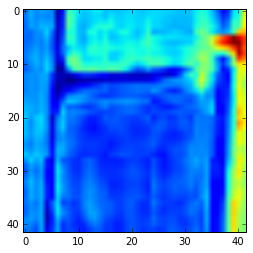

In [516]:
print(Class_label)
plt.imshow(inputPatch)

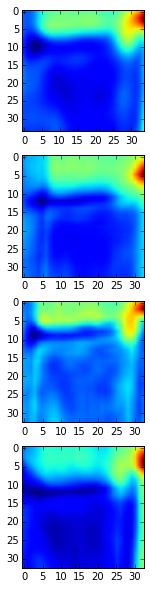

In [517]:
plt.figure(figsize=(10,10))
for i in range(0,len(C1)):
        plt.subplot(len(C1),1,i)
        plt.imshow(H1[i])   

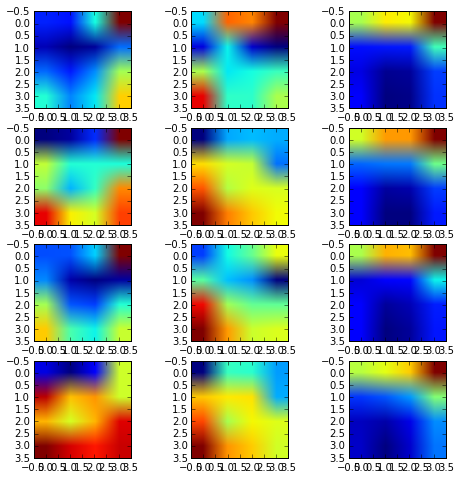

In [518]:
plt.figure(figsize=(8,8))
for i in range(0,len(C1)):
    for j in range(0,N_branches):
        plt.subplot(len(C1),N_branches,(i*N_branches)+j)
        plt.imshow(H4[i][j])   

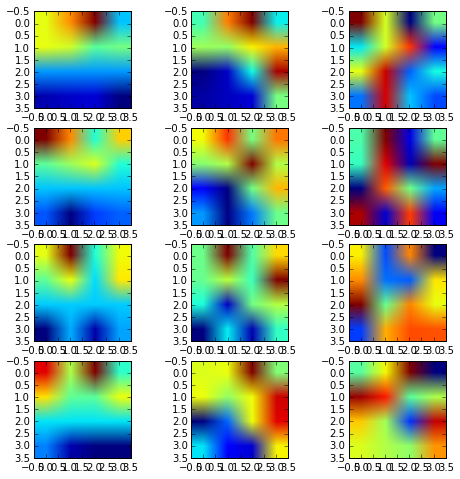

In [519]:
plt.figure(figsize=(8,8))
for i in range(0,len(C1)):
    for j in range(0,N_branches):
        plt.subplot(len(C1),N_branches,(i*N_branches)+j)
        plt.imshow(C2[i][j])    

# save training parameters

In [245]:
with open("C2.txt", 'w') as f:
    f.write(str(C2))
with open("W.txt", 'w') as f:
    f.write(str(W))
with open("H3_bias.txt", 'w') as f:
    f.write(str(H3_bias))
with open("Bias.txt", 'w') as f:
    f.write(str(bias))
            
